In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

In [30]:
FILES = {
    "patient": "sim_av_patient_c34.csv",
    "tumour": "sim_av_tumour_c34.csv",
    "gene": "sim_av_gene_c34.csv",
    "combined": "sim_rtds_combined_c34.csv",
    "episode": "sim_rtds_episode_c34.csv",
    "exposure": "sim_rtds_exposure_c34.csv",
    "presc": "sim_rtds_prescription_c34.csv",
}

In [31]:
ID_COL = "PATIENTID"

In [32]:
GENES_OF_INTEREST = ["PMS2", "CD274"]

In [33]:
def read_csv_keep_id(path, parse_dates=None):
    df = pd.read_csv(path, dtype={ID_COL: "string"}, parse_dates=parse_dates)
    df.columns = [c.strip().upper() for c in df.columns]
    df[ID_COL] = df[ID_COL].astype("string").str.strip()
    return df

In [34]:
def strip_upper_obj(df, exclude_cols=()):
    for c in df.select_dtypes(include="object").columns:
        if c not in exclude_cols:
            df[c] = df[c].astype("string").str.strip().str.upper()
    return df

In [35]:
def compress_memory(df):
    for c in df.select_dtypes(include="object").columns:
        if c != ID_COL:
            df[c] = pd.to_numeric(df[c], errors="ignore")
    for c in df.select_dtypes(include="int").columns:
        df[c] = pd.to_numeric(df[c], downcast="integer")
    for c in df.select_dtypes(include="float").columns:
        df[c] = pd.to_numeric(df[c], downcast="float")
    return df

In [36]:
def validate_merge(left, right, on, how="left", validate="many_to_one", **kwargs):
    return left.merge(right, on=on, how=how, validate=validate, **kwargs)

In [37]:
def one_row_per_patient(df, agg=None):
    if agg:
        return df.groupby(ID_COL, as_index=False).agg(agg)
    else:
        return df.drop_duplicates(ID_COL, keep="first")

In [38]:
patient   = read_csv_keep_id(FILES["patient"])
tumour    = read_csv_keep_id(FILES["tumour"])
gene      = read_csv_keep_id(FILES["gene"])
combined  = read_csv_keep_id(FILES["combined"])
episode   = read_csv_keep_id(FILES["episode"])
exposure  = read_csv_keep_id(FILES["exposure"])
presc     = read_csv_keep_id(FILES["presc"])

/var/folders/jq/hfkg7zm125v21zscmmsg0snh0000gr/T/ipykernel_3122/853354600.py:2: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, dtype={ID_COL: "string"}, parse_dates=parse_dates)
/var/folders/jq/hfkg7zm125v21zscmmsg0snh0000gr/T/ipykernel_3122/853354600.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, dtype={ID_COL: "string"}, parse_dates=parse_dates)
/var/folders/jq/hfkg7zm125v21zscmmsg0snh0000gr/T/ipykernel_3122/853354600.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, dtype={ID_COL: "string"}, parse_dates=parse_dates)


In [39]:
for df in [patient, tumour, gene, combined, episode, exposure, presc]:
    strip_upper_obj(df, exclude_cols=(ID_COL,))


Checking missing values in patient dataset:


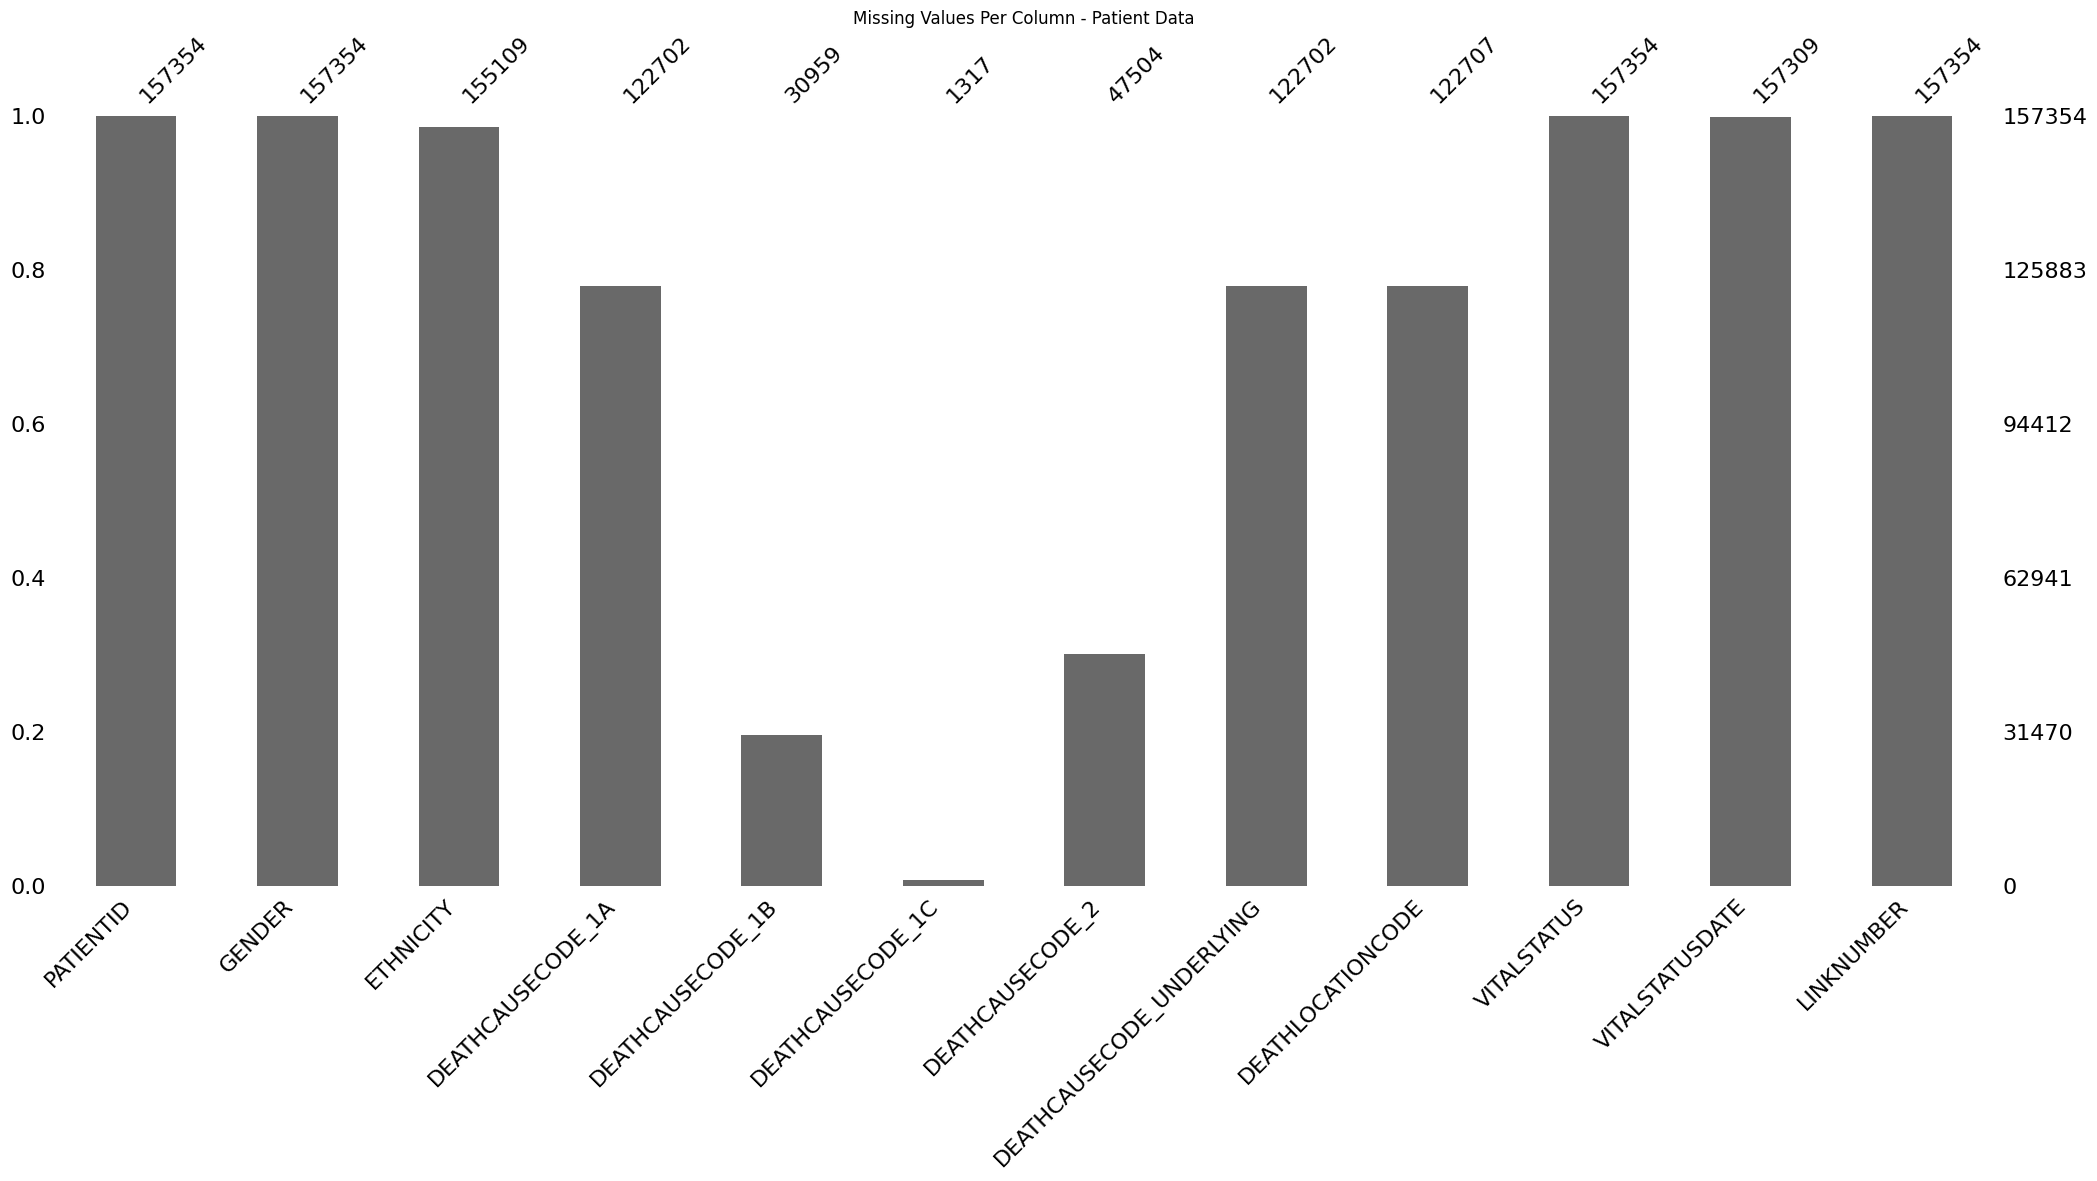

In [40]:
print("\nChecking missing values in patient dataset:")
msno.bar(patient)
plt.title("Missing Values Per Column - Patient Data")
plt.show()

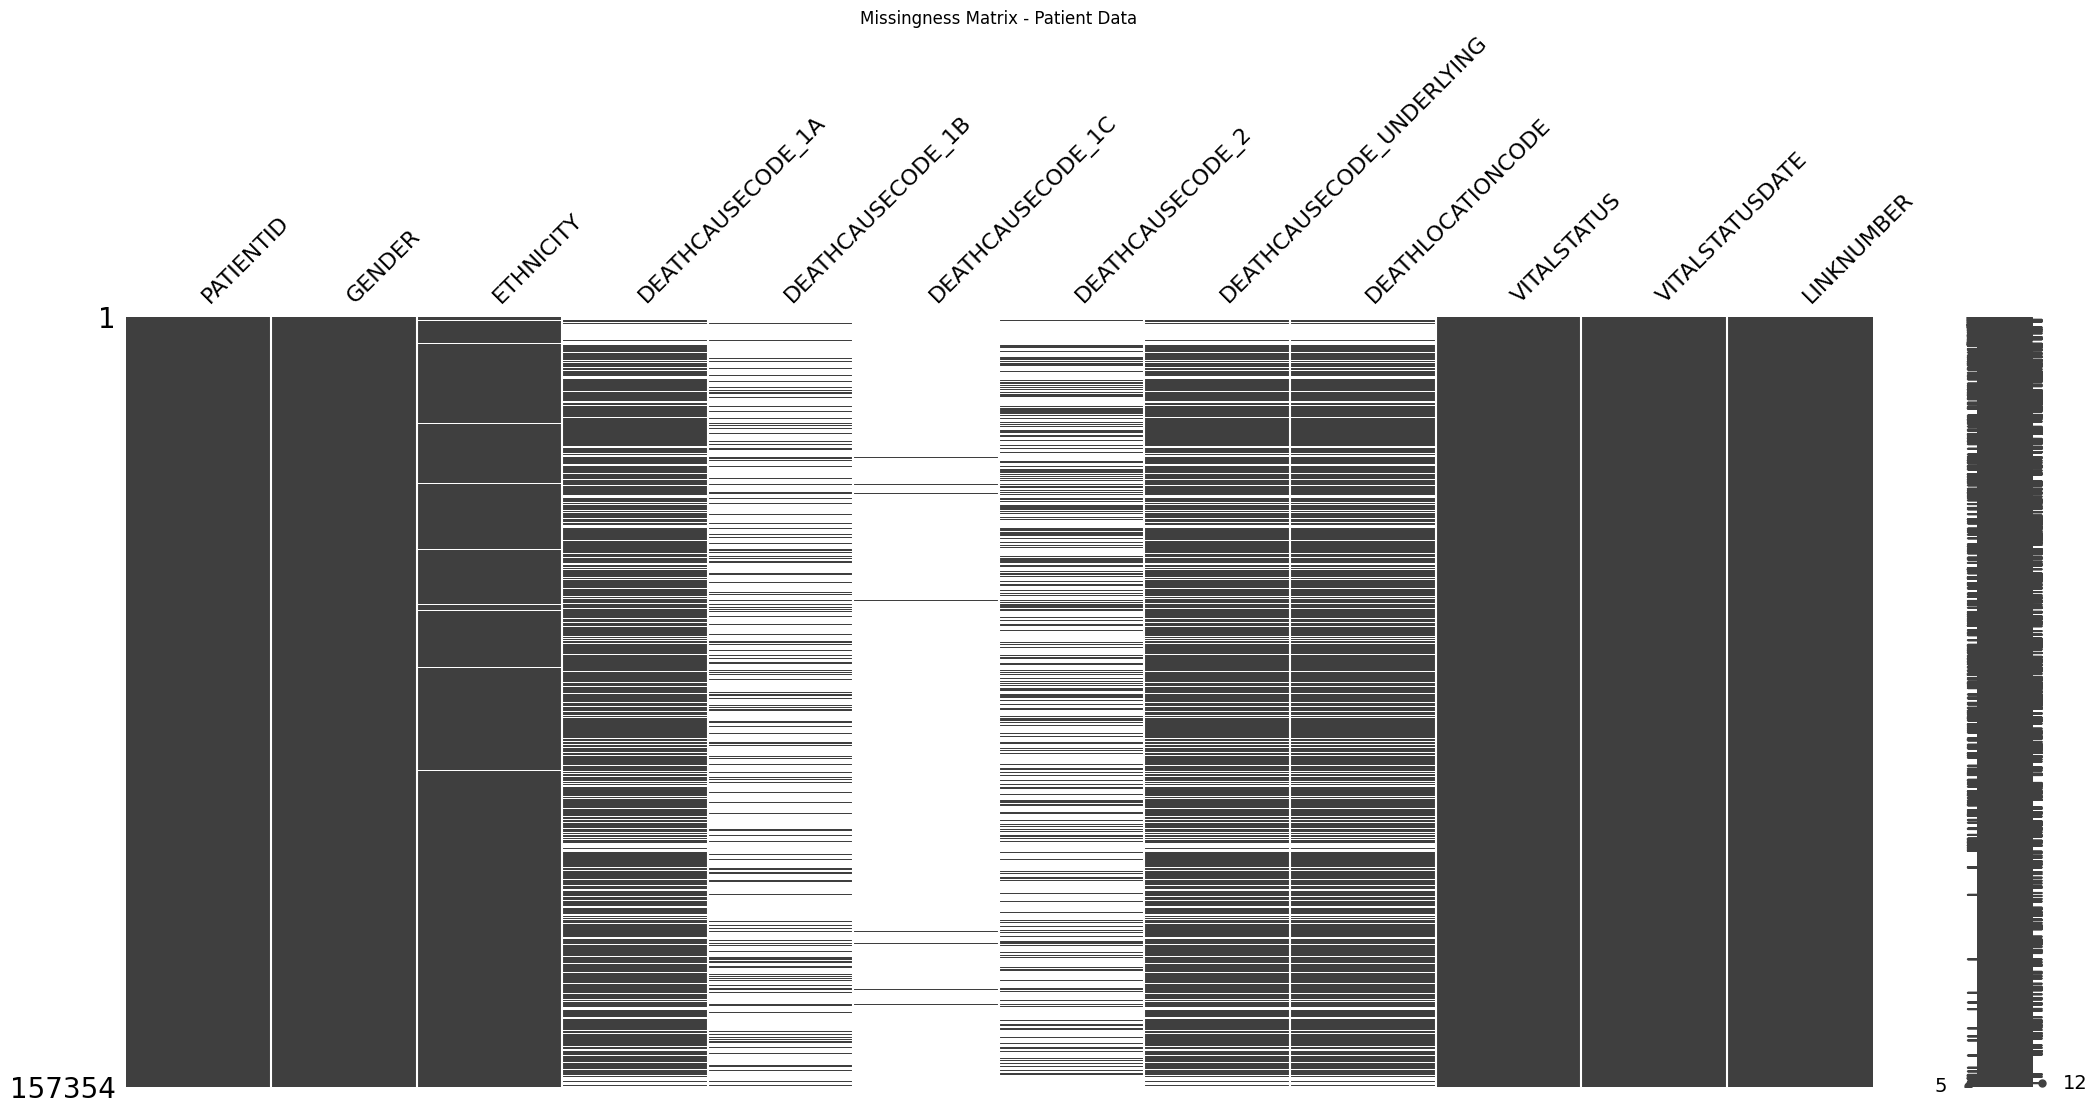

In [41]:
msno.matrix(patient)
plt.title("Missingness Matrix - Patient Data")
plt.show()

In [42]:
tumour_agg   = one_row_per_patient(tumour)
combined_agg = one_row_per_patient(combined)
episode_agg  = one_row_per_patient(episode, agg={"EPISODE_ID": "nunique"} if "EPISODE_ID" in episode.columns else None)
exposure_agg = one_row_per_patient(exposure, agg={"EXPOSURE_ID": "nunique"} if "EXPOSURE_ID" in exposure.columns else None)
presc_agg    = one_row_per_patient(presc, agg={"PRESCRIPTION_ID": "nunique"} if "PRESCRIPTION_ID" in presc.columns else None)

In [43]:
gene["GENE_DESC"] = gene["GENE_DESC"].astype("string").str.upper().str.strip()
gene_flags = (
    gene.assign(val=1)
        .pivot_table(index=ID_COL, columns="GENE_DESC", values="val", aggfunc="max", fill_value=0)
        .reset_index()
)

In [44]:
master = patient.copy()
master = validate_merge(master, tumour_agg,   on=ID_COL, validate="one_to_one", suffixes=("", "_TUMOUR"))
master = validate_merge(master, combined_agg, on=ID_COL, validate="one_to_one", suffixes=("", "_COMB"))
master = validate_merge(master, episode_agg,  on=ID_COL, validate="one_to_one", suffixes=("", "_EP"))
master = validate_merge(master, exposure_agg, on=ID_COL, validate="one_to_one", suffixes=("", "_EXP"))
master = validate_merge(master, presc_agg,    on=ID_COL, validate="one_to_one", suffixes=("", "_RX"))
master = validate_merge(master, gene_flags,   on=ID_COL, validate="one_to_one")

master = compress_memory(master)

print(f"\nMaster dataset: {len(master):,} rows | {master[ID_COL].nunique():,} unique patients")


Master dataset: 157,354 rows | 157,354 unique patients


In [45]:
gender_map = {"1": "male", "2": "female", 1: "male", 2: "female"}
if "GENDER" in master.columns:
    master["SEX_LABEL"] = master["GENDER"].astype(str).str.strip().map(gender_map)
else:
    master["SEX_LABEL"] = pd.NA

if "ETHNICITY" in master.columns:
    master["ETHNICITY"] = master["ETHNICITY"].astype("category")

/var/folders/jq/hfkg7zm125v21zscmmsg0snh0000gr/T/ipykernel_3122/1192995155.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  master["SEX_LABEL"] = master["GENDER"].astype(str).str.strip().map(gender_map)


In [46]:
chi_results = []
for g in GENES_OF_INTEREST:
    col = g.upper()
    if col in master.columns:
        df_temp = master.dropna(subset=["SEX_LABEL"]).copy()
        table = pd.crosstab(df_temp["SEX_LABEL"], df_temp[col])
        if table.shape == (2, 2):  # Must have both sexes + presence/absence
            chi2, p, _, _ = chi2_contingency(table.values)
            chi_results.append({"gene": g, "p_value": p, "table": table})

chi_df = pd.DataFrame(chi_results).sort_values("p_value")
print("\nChi-square results:")
print(chi_df)


Chi-square results:
   gene   p_value                                              table
0  PMS2  0.983956  PMS2         0.0  1.0
SEX_LABEL            
fe...


/var/folders/jq/hfkg7zm125v21zscmmsg0snh0000gr/T/ipykernel_3122/498922001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=chi_df, x="p_value", y="gene", palette="viridis")


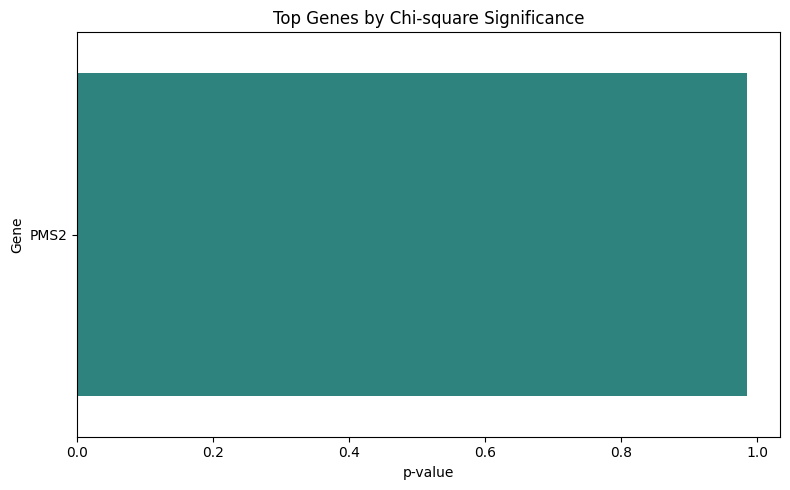

In [47]:
if not chi_df.empty:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=chi_df, x="p_value", y="gene", palette="viridis")
    plt.title("Top Genes by Chi-square Significance")
    plt.xlabel("p-value")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()

In [48]:
try:
    if "ETHNICITY" in master.columns:
        for g in GENES_OF_INTEREST:
            col = g.upper()
            if col in master.columns and master[col].nunique() == 2:
                formula = f"{col} ~ C(ETHNICITY)"
                model = smf.logit(formula=formula, data=master).fit(disp=False)
                print(f"\n=== Logistic Regression: {g} ===")
                print(model.summary())
except Exception as e:
    print("Logistic regression skipped:", e)

# Final clean dataframe
master.head()

Logistic regression skipped: Error converting data to categorical: observation with value <NA> does not match any of the expected levels (expected: ['0', 'A', ..., 'X', 'Z'])
    PMS2 ~ C(ETHNICITY)
           ^^^^^^^^^^^^


,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,...,SMAD4,SS18,STK11,TERT,TP53,TSC1,TSC2,VHL,YWHAE,SEX_LABEL
0,10175206,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
1,10175273,1,A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male
2,10175282,1,Z,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
3,10175292,1,Z,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male
4,10175333,1,A,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male


In [3]:
dataframes["sim_av_gene_c34"].head(5)

,GENEID,TUMOURID,PATIENTID,GENE_DESC,GENE,COUNT_TESTS,COUNT_RESULTS,COUNT_DATE,ALL_TESTSTATUSES,OVERALL_TS,...,SEQ_VAR,DATE_OVERALL_TS,BEST_DATE_SOURCE_OVERALL_TS,MIN_DATE,MAX_DATE,ALL_PRO_IMPS,NO_OF_PRO_IMPS,PRO_IMP,METHODS,LAB_NAME
0,10037483,11641162,10243109,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2018-01-22,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,10037484,11723811,10243117,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2018-03-25,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,10037492,11502311,10243418,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-01-26,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,10037495,10073014,10243465,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-05-15,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,10037528,10014582,10244392,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-01-12,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [4]:
for name, df in dataframes.items():
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).str.strip().str.upper()
    print(f"Cleaned string columns in {name}")


Cleaned string columns in sim_av_tumour_c34
Cleaned string columns in sim_av_patient_c34
Cleaned string columns in sim_av_gene_c34
Cleaned string columns in sim_rtds_combined_c34
Cleaned string columns in sim_rtds_episode_c34
Cleaned string columns in sim_rtds_exposure_c34
Cleaned string columns in sim_rtds_prescription_c34


In [5]:
from scipy import stats
import matplotlib.pyplot as plt

In [7]:
def downcast_dataframes(df):
    # Try to parse numerics from object columns first
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='ignore')
    # Then downcast numerics
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

In [9]:
def compress_objects(df, max_ratio=0.5):
    n = len(df)
    for col in df.select_dtypes(include='object').columns:
        # Only convert if not mostly-unique strings
        if n and (df[col].nunique(dropna=False) / n) <= max_ratio:
            df[col] = df[col].astype('category')
    return df

In [10]:
sorted_genes = sorted(dataframes["sim_av_gene_c34"]['GENE_DESC'].unique())
print(sorted_genes)

['ACVR1', 'AKT1', 'AKT3', 'ALK', 'APC', 'AR', 'BCL2', 'BCL6', 'BCOR', 'BMPR1A', 'BRAF', 'BRCA1', 'BRCA2', 'CALR', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CD274 (PD-L1)', 'CDH1', 'CDK2', 'CDK4', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDX2', 'CEBPA', 'CHEK2', 'CIC', 'CTNNB1', 'DDR2', 'EGFR', 'ERBB2 (HER2 / NEU)', 'ERBB3', 'ETV6', 'EWSR1', 'FGFR1', 'FGFR2', 'FGFR3', 'FLT3', 'FOXO1', 'FUS', 'GNA11', 'GNAQ', 'H3F3A', 'HIST1H3B', 'HRAS', 'IDH1', 'IDH2', 'IGF1R', 'JAK2', 'KIT', 'KRAS', 'MALT1', 'MAP2K1 (MEK1)', 'MAP2K4', 'MCL1', 'MDM2', 'MET', 'MGMT', 'MLH1', 'MPL', 'MSH2', 'MSH6', 'MUTYH', 'MYB', 'MYC', 'MYCN', 'MYD88', 'NF1', 'NPM1', 'NR4A3', 'NRAS', 'NTRK1', 'NTRK2', 'NTRK3', 'PDGFB', 'PDGFRA', 'PDGFRB', 'PIK3CA', 'PIK3R4', 'PMS2', 'POLD1', 'POLE', 'POLE2', 'PTEN', 'RB1', 'RELA', 'RET', 'ROS1', 'RUNX1', 'SDHB', 'SF3B1', 'SMAD4', 'SS18', 'STK11', 'TERT', 'TP53', 'TSC1', 'TSC2', 'VHL', 'YWHAE']


In [15]:
df_lung = dataframes["sim_av_patient_c34"].copy()

In [16]:
df_lung = downcast_dataframes(df_lung)
df_lung = compress_objects(df_lung)

/var/folders/jq/hfkg7zm125v21zscmmsg0snh0000gr/T/ipykernel_3122/1594020842.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [21]:
df_lung = df_lung.merge(dataframes["sim_av_tumour_c34"], on='PATIENTID', how='left', suffixes=('', '_tumour')) #ran

ValueError: You are trying to merge on int32 and object columns for key 'PATIENTID'. If you wish to proceed you should use pd.concat

In [12]:
downcast_dataframes(df_lung)

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,...,QUINTILE_2019,DATE_FIRST_SURGERY,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CHRL_TOT_27_03,COMORBIDITIES_27_03,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED
0,10175206,1,NAN,NAN,NAN,NAN,NAN,NAN,NAN,A,...,3,NAN,C,1.0,3.0,"01,05,09",NAN,NAN,NAN,NAN
1,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,3,NAN,9,1.0,1.0,04,NAN,NAN,NAN,NAN
2,10175282,1,Z,NAN,NAN,NAN,NAN,NAN,NAN,A,...,4,NAN,9,3.0,0.0,NAN,NAN,NAN,NAN,NAN
3,10175292,1,Z,NAN,NAN,NAN,NAN,NAN,NAN,A,...,3,NAN,NAN,NAN,0.0,NAN,NAN,NAN,NAN,NAN
4,10175333,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,4,NAN,NAN,3.0,6.0,"04,06,11,12",NAN,NAN,NAN,NAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159527,250002505,2,A,C445,NAN,NAN,NAN,C809,1,D,...,4,2019-06-07,NAN,NAN,0.0,NAN,NAN,NAN,NAN,NAN
159528,250002507,2,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,5 - LEAST DEPRIVED,2017-04-19,NAN,9.0,0.0,NAN,NAN,NAN,NAN,NAN
159529,250002519,2,J,NAN,NAN,NAN,NAN,NAN,NAN,A,...,1 - MOST DEPRIVED,2019-09-03,NAN,NAN,3.0,"06,13",NAN,NAN,NAN,NAN
159530,250002530,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,1 - MOST DEPRIVED,2018-09-07,NAN,NAN,0.0,NAN,NAN,4.0,NAN,NAN


In [13]:
df_lung = df_lung.merge(dataframes["sim_av_gene_c34"], on='PATIENTID', how='left') #ran

In [14]:
downcast_dataframes(df_lung)

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,...,SEQ_VAR,DATE_OVERALL_TS,BEST_DATE_SOURCE_OVERALL_TS,MIN_DATE,MAX_DATE,ALL_PRO_IMPS,NO_OF_PRO_IMPS,PRO_IMP,METHODS,LAB_NAME
0,10175206,1,NAN,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NAN,2019-11-09,1)AUTHORISEDDATE,NAN,NAN,NAN,0,NAN,NAN,BRISTOL (MOLECULAR LAB)
1,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10175282,1,Z,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NAN,2017-08-07,1)AUTHORISEDDATE,NAN,NAN,NAN,0,NAN,NAN,NEWCASTLE (MOLECULAR LAB)
3,10175282,1,Z,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NAN,2017-09-16,1)AUTHORISEDDATE,NAN,NAN,NAN,0,NAN,NAN,NAN
4,10175292,1,Z,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217969,250002505,2,A,C445,NAN,NAN,NAN,C809,1,D,...,NAN,2019-12-26,NAN,NAN,NAN,NAN,0,NAN,NAN,NAN
217970,250002507,2,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217971,250002519,2,J,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217972,250002530,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_lung = df_lung.merge(dataframes["sim_rtds_combined_c34"], on='PATIENTID', how='left', suffixes=('', '_tumour'))

In [16]:
downcast_dataframes(df_lung)

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,...,DECISIONTOTREATDATE,EARLIESTCLINAPPROPDATE,RADIOTHERAPYEPISODEID,LINKCODE,RADIOISOTOPE,RADIOTHERAPYBEAMTYPE,RADIOTHERAPYBEAMENERGY,TIMEOFEXPOSURE,APPTDATE,ATTENDID
0,10175206,1,NAN,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-07-23,2014-07-22,1232134,LBH,NAN,T2,6.0,1899-,2014-08-05,10013247.20140805
2,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-07-23,2014-07-22,1232134,LBH,NAN,T7,0.08,09:08,2014-08-06,10013247.20140806
3,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-11-11,2014-11-14,1207415,LEJ,NAN,T1,6.0,11:36,2014-11-29,10046796.20141129
4,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-11-11,2014-11-14,1207415,LEJ,NAN,T1,6.0,16:50,2014-12-14,10046796.20141214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598414,250002505,2,A,C445,NAN,NAN,NAN,C809,1,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1598415,250002507,2,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1598416,250002519,2,J,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1598417,250002530,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_lung = df_lung.merge(dataframes["sim_rtds_episode_c34"], on='PATIENTID', how='left', suffixes=('', '_tumour'))

In [19]:
downcast_dataframes(df_lung)

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,...,APPTDATE,ATTENDID,RADIOTHERAPYEPISODEID_tumour,ATTENDID_tumour,APPTDATE_tumour,LINKCODE_tumour,DECISIONTOTREATDATE_tumour,EARLIESTCLINAPPROPDATE_tumour,RADIOTHERAPYPRIORITY_tumour,RADIOTHERAPYINTENT_tumour
0,10175206,1,NAN,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-08-05,10013247.20140805,1232134,10013247.20140805,2014-08-05,LBH,2014-07-23,2014-07-22,R,2.0
2,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-08-05,10013247.20140805,1232134,10013247.20140806,2014-08-06,LBH,2014-07-23,2014-07-22,R,2.0
3,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-08-05,10013247.20140805,1207415,10046796.20141129,2014-11-29,LEJ,2014-11-11,2014-11-14,R,2.0
4,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-08-05,10013247.20140805,1207415,10046796.20141214,2014-12-14,LEJ,2014-11-11,2014-11-14,R,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24260813,250002505,2,A,C445,NAN,NAN,NAN,C809,1,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24260814,250002507,2,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24260815,250002519,2,J,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24260816,250002530,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_lung

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,...,APPTDATE,ATTENDID,RADIOTHERAPYEPISODEID_tumour,ATTENDID_tumour,APPTDATE_tumour,LINKCODE_tumour,DECISIONTOTREATDATE_tumour,EARLIESTCLINAPPROPDATE_tumour,RADIOTHERAPYPRIORITY_tumour,RADIOTHERAPYINTENT_tumour
0,10175206,1,NAN,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-08-05,10013247.20140805,1232134,10013247.20140805,2014-08-05,LBH,2014-07-23,2014-07-22,R,2.0
2,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-08-05,10013247.20140805,1232134,10013247.20140806,2014-08-06,LBH,2014-07-23,2014-07-22,R,2.0
3,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-08-05,10013247.20140805,1207415,10046796.20141129,2014-11-29,LEJ,2014-11-11,2014-11-14,R,2.0
4,10175273,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,2014-08-05,10013247.20140805,1207415,10046796.20141214,2014-12-14,LEJ,2014-11-11,2014-11-14,R,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24260813,250002505,2,A,C445,NAN,NAN,NAN,C809,1,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24260814,250002507,2,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24260815,250002519,2,J,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24260816,250002530,1,A,NAN,NAN,NAN,NAN,NAN,NAN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_lung = df_lung.merge(dataframes["sim_rtds_exposure_c34"], on='PATIENTID', how='left', suffixes=('', '_tumour'))

: 

In [ ]:
downcast_dataframes(df_lung)

In [ ]:
df_lung = df_lung.merge(dataframes["sim_rtds_prescription_c34"], on='PATIENTID', how='left', suffixes=('', '_tumour'))

In [ ]:
downcast_dataframes(df_lung)

In [ ]:
df_lung.head(5)

In [ ]:
unique_genes = sim_av_gene_c34['GENE_DESC'].unique()
print("Number of unique genes:", len(unique_genes))
print("List of unique genes:", unique_genes)


In [ ]:
print(df_lung.columns.tolist())

In [ ]:
#merged_df can be changed to what the df is called

In [ ]:
# Define the mapping
sex_map = {1: 'male', 2: 'female'}

# Apply it to the column
df_lung['sex_label'] = df_lung['GENDER'].map(sex_map)


In [ ]:
print(df_lung[['GENDER', 'sex_label']].tail(10))


In [ ]:
for col in df_lung.columns:
    if df_lung[col].dtype == 'object':
        df_lung[col] = df_lung[col].astype(str)


In [ ]:
print(df_lung['GENE_DESC'].tail(10))

In [ ]:
# Count how many times each gene appears per sex
gene_sex_counts = df_lung.groupby(['GENE_DESC', 'GENDER']).size().unstack(fill_value=0)


In [ ]:
print(gene_sex_counts.head())


In [ ]:
from scipy.stats import chi2_contingency

results = []

for gene, row in gene_sex_counts.iterrows():
    male_count = row.get('male', 0)
    female_count = row.get('female', 0)

    if male_count == 0 or female_count == 0:
        continue  # Skip invalid rows

    contingency = [[male_count, female_count], [1, 1]]  # Dummy row to avoid zero
    chi2, p, _, _ = chi2_contingency(contingency)

    results.append({
        'gene': gene,
        'male_count': male_count,
        'female_count': female_count,
        'p_value': p
    })



In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df.head(5)

In [ ]:
print(results_df.columns)


In [ ]:
# Sort by p-value
results_df = results_df.sort_values(by='p_value')

# Filter for significant results
significant_genes = results_df[results_df['p_value'] < 0.05]


In [ ]:
print(significant_genes.head(10))  # Top 10 significant genes


In [ ]:
sns.barplot(data=significant_genes.head(10), x='p_value', y='gene')

In [ ]:
unique_ethnicities = sim_av_patient_c34['ETHNICITY'].unique()
print("Number of ethnicity categories:", len(unique_ethnicities))
print("Ethnicity categories:", sorted(unique_ethnicities))


In [ ]:
#logistic regression for ethnicity and risk genes

import statsmodels.api as sm
import statsmodels.formula.api as smf

merged_df['PMS2_binary'] = (merged_df['PMS2'] > merged_df['PMS2'].median()).astype(int)
merged_df['CD274_binary'] = (merged_df['CD274'] > merged_df['CD274'].median()).astype(int)

merged_df['ethnicity'] = merged_df['ethnicity'].astype('category')

model_pms2 = smf.logit('PMS2_binary ~ C(ethnicity)', data=merged_df).fit()
print("PMS2 Logistic Regression:\n", model_pms2.summary())

model_cd274 = smf.logit('CD274_binary ~ C(ethnicity)', data=merged_df).fit()
print("\nCD274 Logistic Regression:\n", model_cd274.summary())
